# Sequence to Sequence Models

We are looking at a new model architecture in NLP today which is used to generate data from text to text, but doesn't it sound similar to RNN? Why the new architecture then?

Knowing about RNNs and Language Models gives us the right fundamentals we need to now understand Sequence to Sequence models. But since it can be confusing, let's be clear about the differences first.



#### **Key Differences**:

- **Input and Output**:
  - **RNN Language Model**: Takes a sequence of words and predicts the next word in the sequence.
  - **Seq2Seq Model**: Takes a sequence of data and transforms it into another sequence.

- **Architecture**:
  - **RNN Language Model**: Typically uses a single RNN.
  - **Seq2Seq Model**: Uses an encoder-decoder architecture with two RNNs.

- **Applications**:
  - **RNN Language Model**: Best suited for text generation and language modeling.
  - **Seq2Seq Model**: Ideal for translation, summarization, and any task that requires sequence transformation.


One important point is that even RNN language models can have multiple layers of RNNs within so it's not about how many RNNs are used but about the architecture which makes these two different as Seq2Seq models have a strikingly different architecture called encoder-decoder architecture.

Why Seq2Seq -> It first become useful for language translation use-cases especially where the **input and output length varies** because in the existing architecture of RNN LMs the each input would generate an output and it would become a 1-1 count. Later it became possible to introduce attention mechanism and other advanced enhancements into this architecture while there was not much scope in RNN LMs. Also you will see later that the use-cases for the seq2seq model are not limited to language translation only. For now let's look at what's inside and how it works.

## Architecture Details

1. The Seq2Seq comprises of an encoder-decoder architecture.
2. The goal of the encoder, which is made up of a single RNN, is to consume the source sentence and produce a single encoding of it to represent the whole sentence.
3. The encoding of the sentence is taken to be the value of the final hidden state of the encoder RNN.
4. The encoding of the input text is hence complete.
5. Now for the decoder, which can be thought of as a conditional language model, conditional on the encoder output, it is also made up of a single RNN.
6. The encoder output (final hidden state of encoder RNN) becomes the initial hidden state for the decoder RNN.
7. If this is:

   * **training**: The decoder RNN generates the next word/state, which is used to calculate the loss. The generated word is then dropped. The actual/true first word is then fed into the next loop of the RNN as input 𝑥. This process continues till \<END\> does not occur in true data.
   
   * **inference**: The decoder RNN generates the next word/state, which is fed into the next loop of the RNN as input 𝑥. This process continues until the \<END\> token is generated.

8. Please note that for both training and inference in the decoder step, the hidden state of the RNN is passed in the same manner consistently.


## Inference

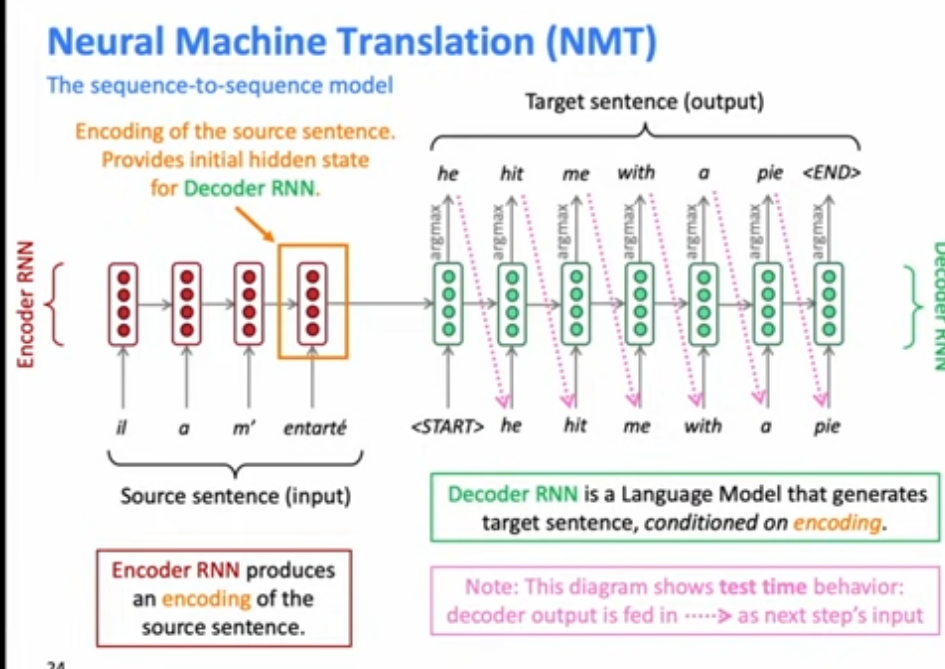

Source: https://www.youtube.com/watch?v=XXtpJxZBa2c&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z&index=10

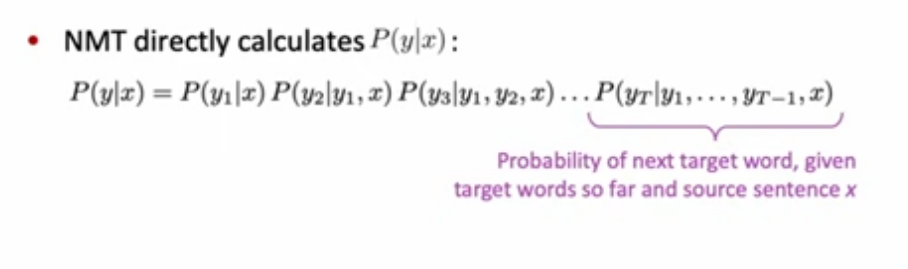

## Training

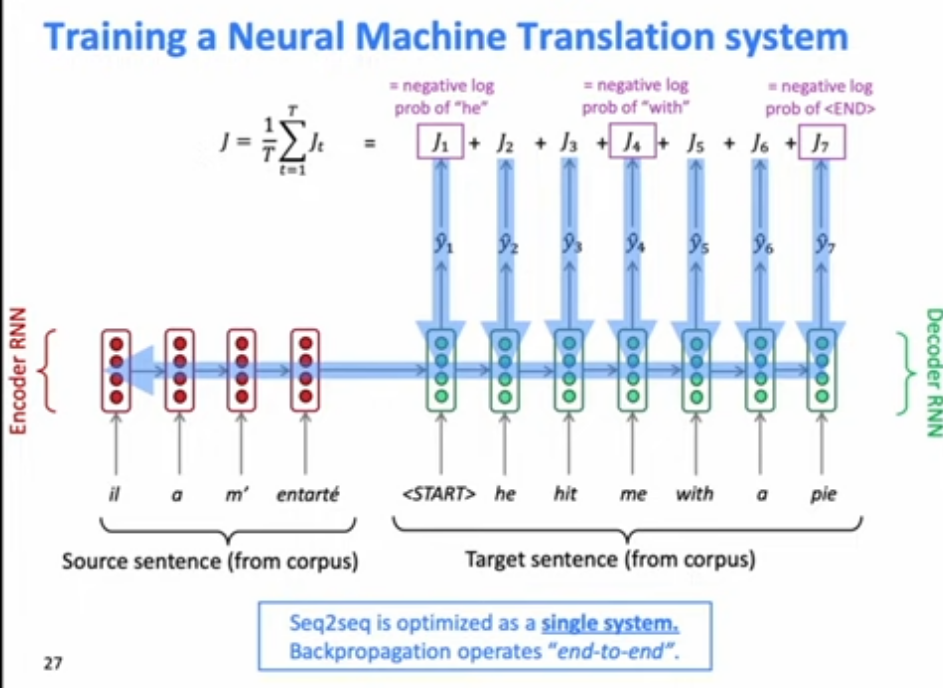

## Working Details

We have understood how the decoder and the encoder work. Especially the decoder, which can be thought of as a conditional language model is picking up the best next words based on the conditional probabilities considering all the input and generations before the next word. But there's a small problem with that approach.
If we carefully consider it, it is a greedy approach to choose the best probability word as the next word, it may give us the best next word but it may not give us the best probability sentence and in the end we may end up with a bunch of bad next words because we chose one that was high probability but didn't make sense as the next word generations came up after it.

For e.g.
The true translation of the sentence as shown in the diagram above is "He hit me with a pie" and we are at a stage where we have generated our first two words "he hit". If at this stage the probability of the next word is higher for "a" rather than "me", then we would be forced to continue with that selection and the generation may look something like "He hit a __" and there's no going back.

#### Beam Search

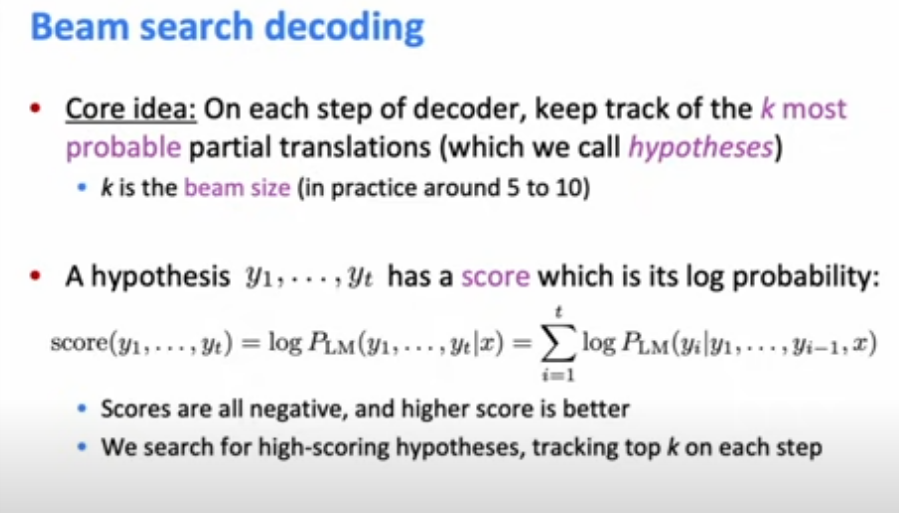


So the solution is to consider more than only the top 1 candidate for the next step, here comes **beam search**. It typically uses top 5-10 probable partial translations at each step and keeps them as separate hypothesis.

Below is an example of the walkthrough:

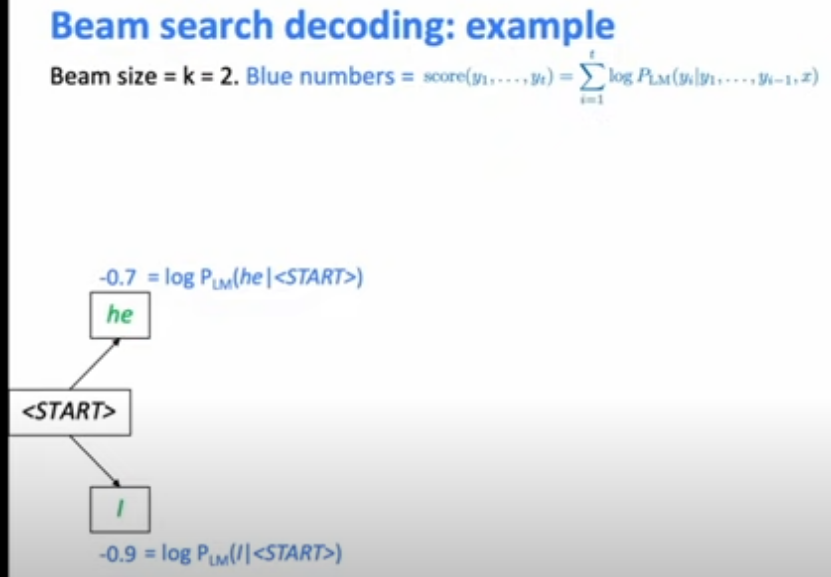


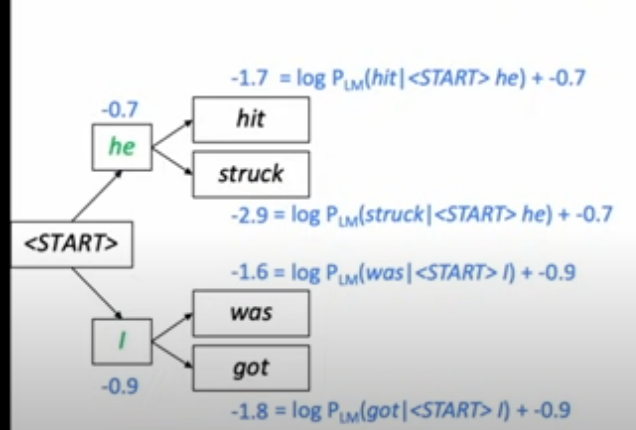


And finally

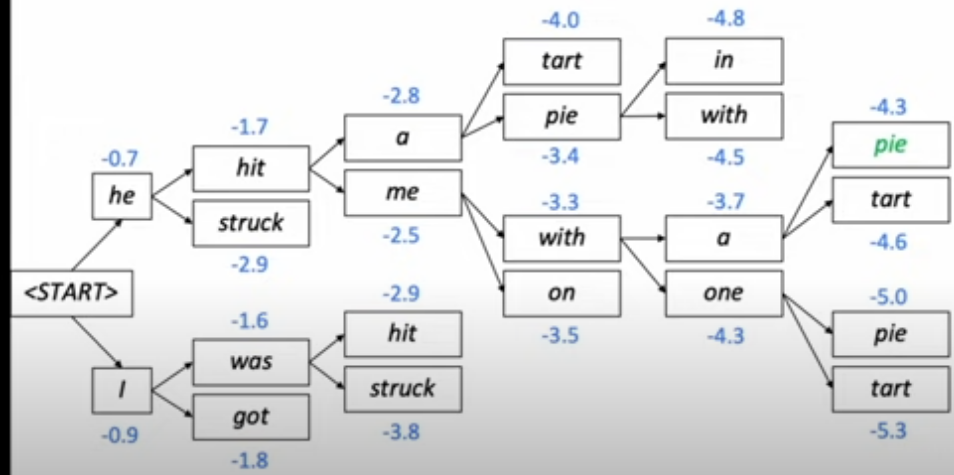

So different hypothesis may generate the \<END\> token at different time-steps, so when one generates the end token we set it aside and evaluate the rest of the hypothesis.
But there's also a stopping criteria in terms of the number of tokens to be generated just in case some of the hypothesis end up becoming too long and simply don't generate the \<END\> token till the limit hits.

But then is there a problem with this approach? Womp Womp, yes and we'll see the fix too (Yeah!)
The score for each partial generation is the log of the probability of the new generation plus the previous score, like a cumulative. So we know the log of all these numbers would be negative (probabilities are numbers between 0 and 1) and when we sum them, the *longer* the hypothesis, or the more words in the final generation the lower the score as compared to the hypothesis which are shorter. So it ends up biasing towards the shorter sentences which is not correct. So we simply fix this by normalizing the score by the length of the hypothesis. 
Here's what the new score would look like:

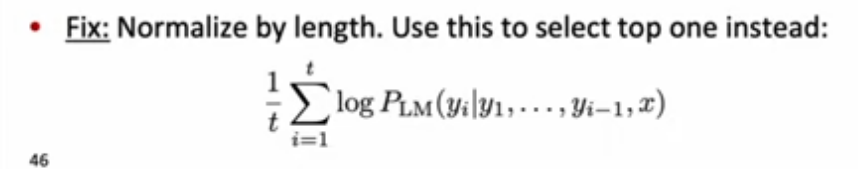


## Model Evaluation and next steps:

The BLEU score is a well used metric to evaluate these models. 
Though there are some issues that this model still faces:
1. Out of vocab words
2. Mismatch between training data dialect and inference data dialect (e.g. formal (Wiki)/informal (tweets))
3. It may pick up biases like gender, age due to training data biases. 
4. Languages with lesser resources or training data
5. Making errors in context when the sequence becomes longer than a length especially since we have a single vector acting as the representation of the whole encoded sequence.


And the last challenge is specifically what the informational bottleneck is and that gave way to the widely known **Attention** technique where 

> the core idea is that on each step of the decoder, it uses a direct connection to the encoder to focus on a particular part of the source 
> sequence. Let's see how we execute that with this first diagram:

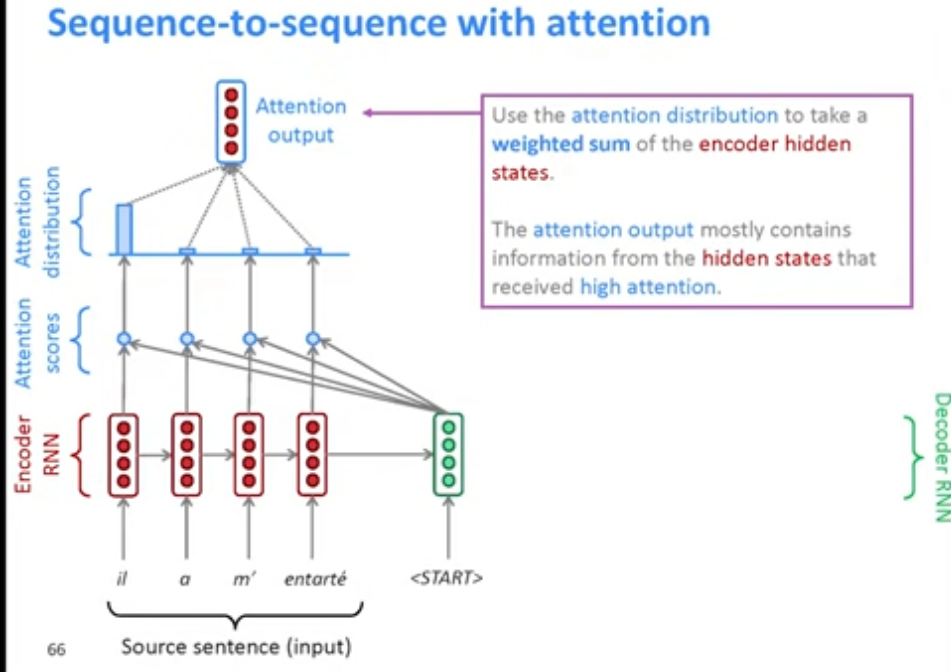

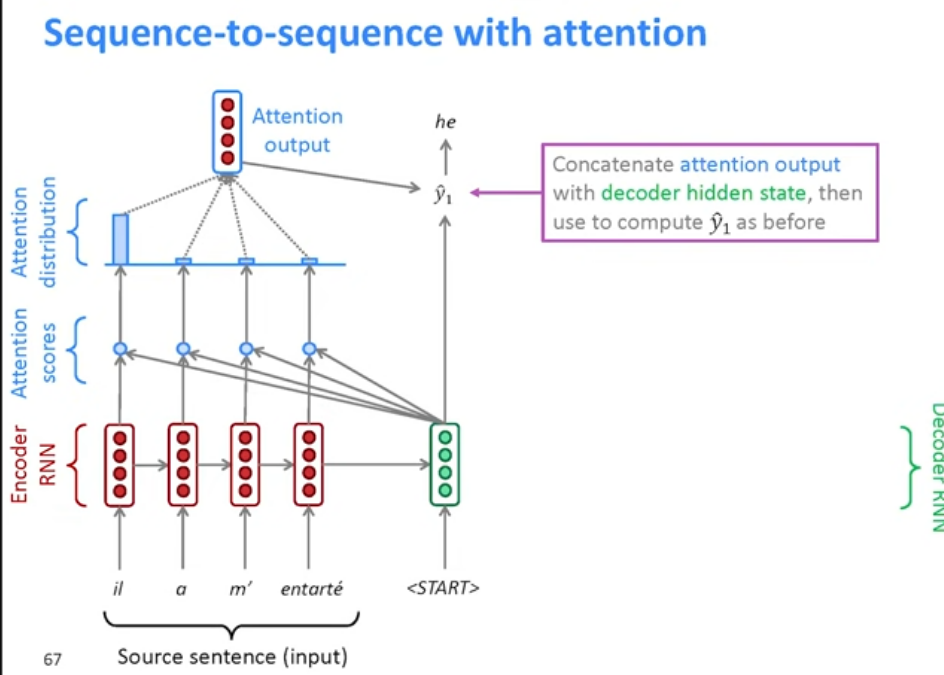

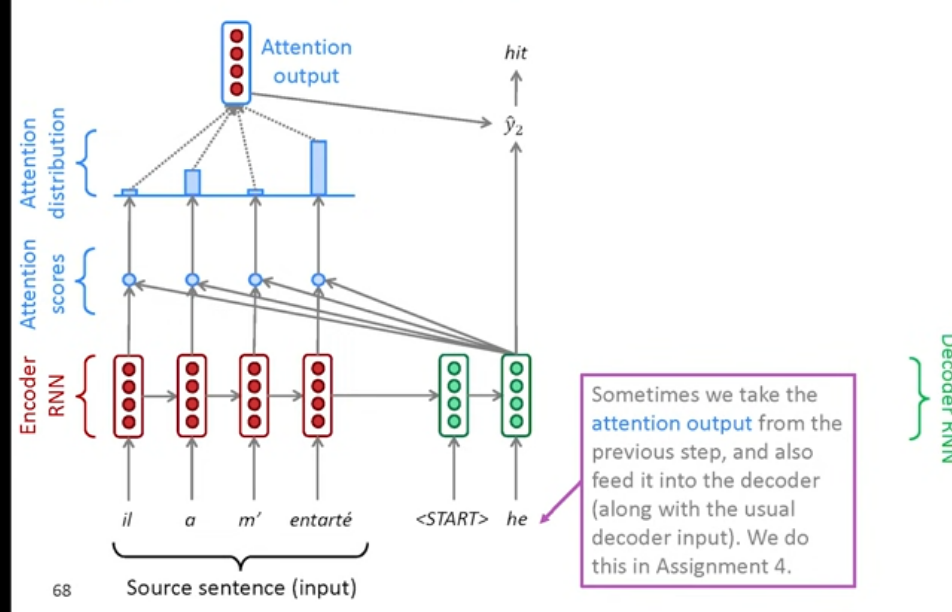

Attention Working:
1. The sequence passes through the encoder RNN and the final hidden state of the encoder is passed to the initial hidden state of the decoder RNN, same as Seq2Seq models.
2. The hidden state generated by decoder RNN at each step is dot-producted with the hidden states of the encoder RNN at each encoder timestep. We can consider this dot product as a measure of similarity as we know that cosine similarity also contains the same calculations. This means that the dot product of the hidden states would be highest where the encoder hidden state is the most similar to the decoder hidden state. So the idea is to find the encoder time step that the decoder generation was the most relatable. 
3. Then after the dot products have been calculated for each encoder time step for a given decoder step, a softmax layer is applied on top to make a probability distribution out of the dot products. 
4. This probability distribution is then used to calculate a weighted sum of the encoder hidden states.
5. This means that the attention output will contain more information from the inputs that had higher attention score, the words which correlate with the decoder generation the most. So in a way this is like saying "Hey decoder, what you generated as a hidden state aligns the most with these input words here from the input sequence".
6. The attention value calculated is concatenated with the same decoder hidden state which was used to calculate the attention and this concatenated value of vector is used to calculate yhat or the decoder generation for that very time step.
7. At the next time step, the attention value calculated in the last time step is also concatenated to the decoder input.

Advantages of Attention:
1. The weighted score allows the decoder to focus on particular input from the input sequence which may be far away.
2. This makes it possible to bypass the bottleneck and look directly at the source.
3. Attention values add some interpretability by helping us understand what the decoder was focusing on when predicting yhat.
4. The weighted attention makes it possible to soft focus on input rather than a 0 and 1 consideration.

This was a starter on attention towards the end. We'll continue with the details on the same in the next notebook. Thanks to Stanford for such amazing learning resources!